In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
path = "../data/results"
base_df = pd.read_json(f"{path}/atsp-out-300.json")
sa_df = pd.read_json(f"{path}/sa-final2-ext-out-40.json")
ts_df = pd.read_json(f"{path}/ts-final-ext-out-50.json")

all_res_df = pd.concat([base_df, sa_df, ts_df], ignore_index=True)

In [3]:
optima = {
    "br17":     39,
    "ft53":   6905,
    "ft70":  38673,
    "ftv33":  1286,
    "ftv35":  1473,
    "ftv38":  1530,
    "ftv44":  1613,
    "ftv47":  1776,
    "ftv55":  1608,
    "ftv64":  1839,
    "ftv70":  1950,
    "ftv90":  1579,
    "ftv100": 1788,
    "ftv110": 1958,
    "ftv120": 2166,
    "ftv130": 2307,
    "ftv140": 2420,
    "ftv150": 2611,
    "ftv160": 2683,
    "ftv170": 2755,
    "kro124p":36230,
    "p43":    5620,
    "rbg323": 1326,
    "rbg358": 1163,
    "rbg403": 2465, 
    "rbg443": 2720,
    "ry48p": 14422,
}
SA_METHODS = ["SA-R", "SA-H"]
TS_METHODS = ["TS-R", "TS-H"]
LS_METHODS = ["S-R", "G-R"]
LS_NN_METHODS = ["S-H", "G-H"]
RANDOM_METHODS = ["R", "RW"]
selected_methods = ["S-R", "G-R", "H", "RW", "R"]
selected_instances = all_res_df["instance"].unique()
COLORS = {
    **dict(zip(selected_methods, sns.palettes.SEABORN_PALETTES["muted"])),
    "S-R":  "#6a9ec3",
    "S-H":  "#14397E",
    "G-H":  "#76330E",
    "SA-R": "#ffff66",
    "SA-H": "#cccc00",
    "TS-R": "#ff3399",
    "TS-H": "#660033"
}
rename_map = {
    "steepest-search": "S-R",
    "steepest-search-nn": "S-H",
    "greedy-search": "G-R",
    "greedy-search-nn": "G-H",
    "nn-heuristic": "H",
    "random": "R",
    "random-walk": "RW",
    "simulated-annealing": "SA-R",
    "simulated-annealing-nn": "SA-H",
    "tabu-search": "TS-R",
    "tabu-search-nn": "TS-H",
}
ORDER = tuple(rename_map.values())

def annotate_ordering(df: pd.DataFrame) -> pd.DataFrame:
    df["instance_size"] = df.instance.apply(lambda x: int(re.search(r'\d+', x).group()))
    df["method_idx"] = df["method"].apply(lambda x: ORDER.index(x))
    return df.sort_values(by=['instance_size', 'method_idx'])


In [4]:
all_res_df["method"] = all_res_df["method"].apply(lambda m: rename_map[m])
all_res_df["distance"] = all_res_df.apply(lambda row: (row['cost'] - optima[row['instance']]) / optima[row['instance']], axis=1)
all_res_df = annotate_ordering(all_res_df)
groupped_df = all_res_df.groupby(['instance', 'method'])[["distance", "time", "iterations", "steps", "evaluations", 'cost']].agg(['mean', 'std', 'min', 'max'])
groupped_df.columns = ["_".join(x) for x in groupped_df.columns]
stats_df = groupped_df.reset_index()
stats_df["instance_size"] = stats_df.instance.apply(lambda x: int(re.search(r'\d+', x).group())) 
stats_df["method_idx"] = stats_df.method.apply(lambda m: ORDER.index(m))
stats_df.head()

stats_df.sort_values(by=["instance_size", "method_idx"], inplace=True)

In [5]:

def plot_violin_by_attr(
        res_df: pd.DataFrame, 
        selected_methods: list[str],
        selected_instances: list[str], 
        attribute: str,
        ax: plt.Axes,
        y_max: int = None,
    ):
    filtered_df = res_df[res_df['method'].isin(selected_methods) & res_df['instance'].isin(selected_instances)]
    sns.violinplot(
        x='instance', 
        y=attribute, 
        hue='method', 
        data=filtered_df, 
        ax=ax,
        linewidth=0, 
        scale='width', 
        palette=COLORS, 
    )
    ax.vlines(
        np.arange(-1, len(selected_instances)) + 0.5, 
        0, 
        filtered_df[attribute].max() if y_max is None else y_max, 
        linestyles='dotted', 
        colors='gray', 
        alpha=0.5,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax


def plot_bars(
    res_df: pd.DataFrame,
    selected_methods: list[str],
    selected_instances: list[str],
    attribute: str,
    ax: plt.Axes,
    err_attribute: str = None,
    x_attr: str = 'instance',
):
    filtered_df = res_df[res_df['method'].isin(selected_methods) & res_df['instance'].isin(selected_instances)]
    sns.barplot(
        x=x_attr, 
        y=attribute, 
        hue='method',
        data=filtered_df, 
        ax=ax,
        palette=COLORS,
    )
    # if err_attribute:
    #     x_coords = np.array([p.get_x() + p.get_width() / 2 for p in ax.patches])
    #     y_coords = np.array([p.get_height() for p in ax.patches])
    #     sorted_idx = np.argsort(x_coords)
    #     x_coords = x_coords[sorted_idx][:filtered_df.shape[0]]
    #     y_coords = y_coords[sorted_idx][:filtered_df.shape[0]]
    #     y_err = filtered_df[err_attribute].to_numpy()
    #     ax.errorbar(x_coords, y_coords, yerr=y_err, fmt='none', ecolor='black', capsize=2)


    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

In [6]:
sns.set_style("ticks")

# Quality

C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


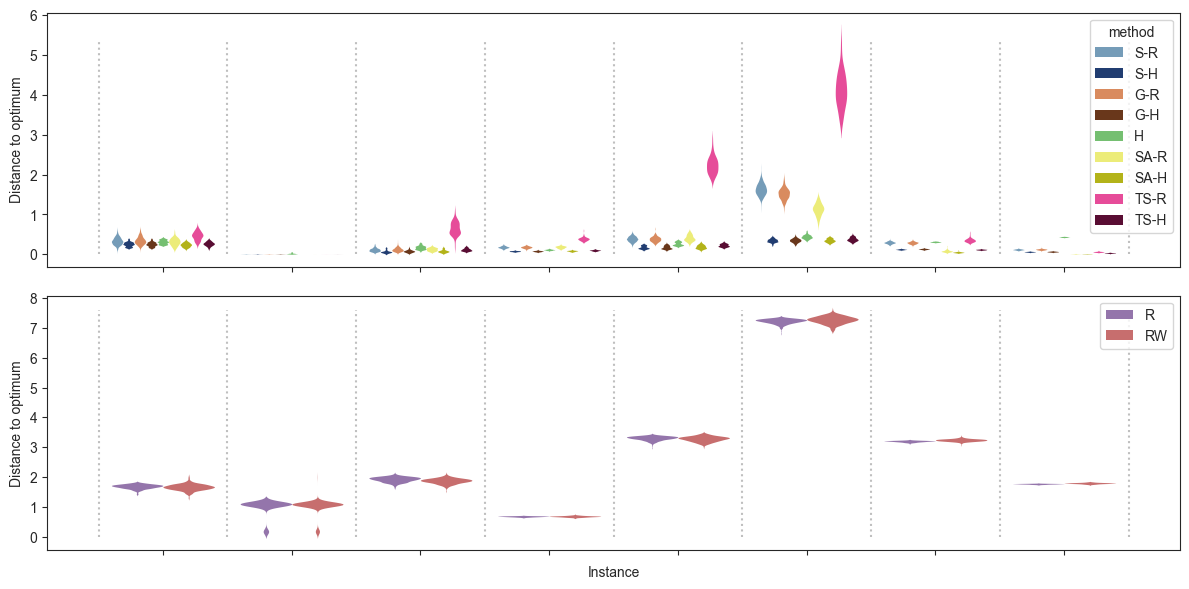

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plot_violin_by_attr(all_res_df, [*LS_METHODS, *LS_NN_METHODS, "H", *TS_METHODS, *SA_METHODS], selected_instances, "distance", axs[0])
plot_violin_by_attr(all_res_df, RANDOM_METHODS, selected_instances, "distance", axs[1])
axs[0].set_xlabel("")
axs[0].set_ylabel("Distance to optimum")
axs[1].set_ylabel("Distance to optimum")
axs[1].set_xlabel("Instance")
axs[1].legend()

plt.tight_layout()
plt.savefig("plots/3/violin_distance.png")
plt.show()

C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


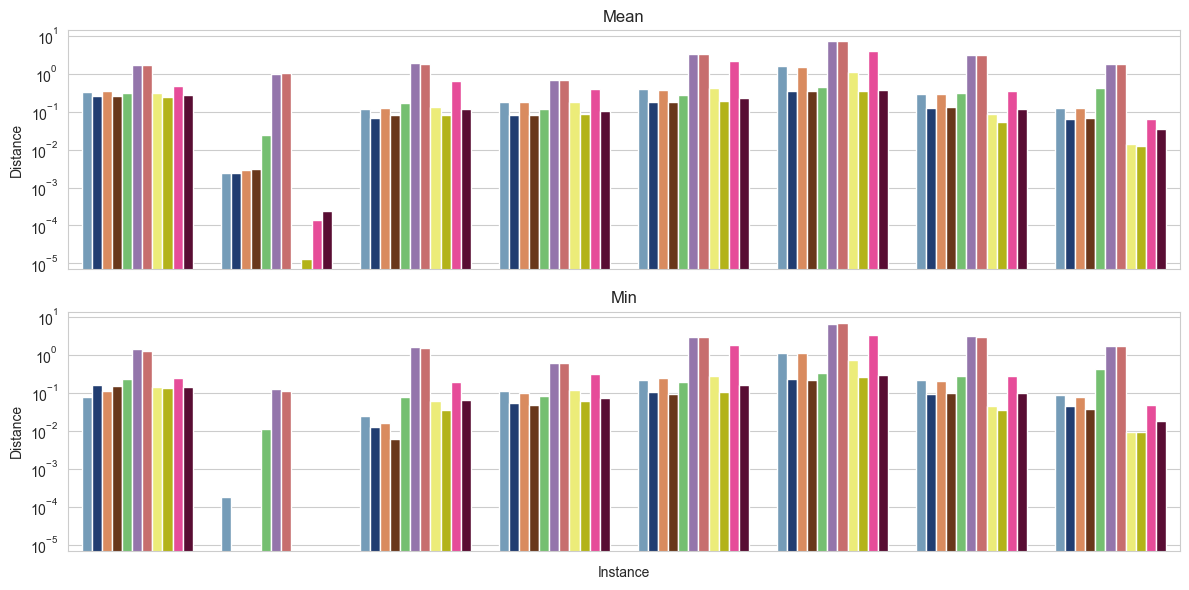

In [8]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharey=True, sharex=True)
    plot_bars(stats_df, ORDER, selected_instances, "distance_mean", axs[0], "distance_std")
    axs[0].set_ylabel("Distance")
    axs[0].set_xlabel("")
    axs[0].set_title("Mean")
    axs[0].legend().remove()
    plot_bars(stats_df, ORDER, selected_instances, "distance_min", axs[1])
    axs[1].legend().remove()
    axs[1].set_ylabel("Distance")
    axs[1].set_xlabel("Instance")
    axs[1].set_title("Min")
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig("plots/3/bar_distance.png")
    plt.show()

C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


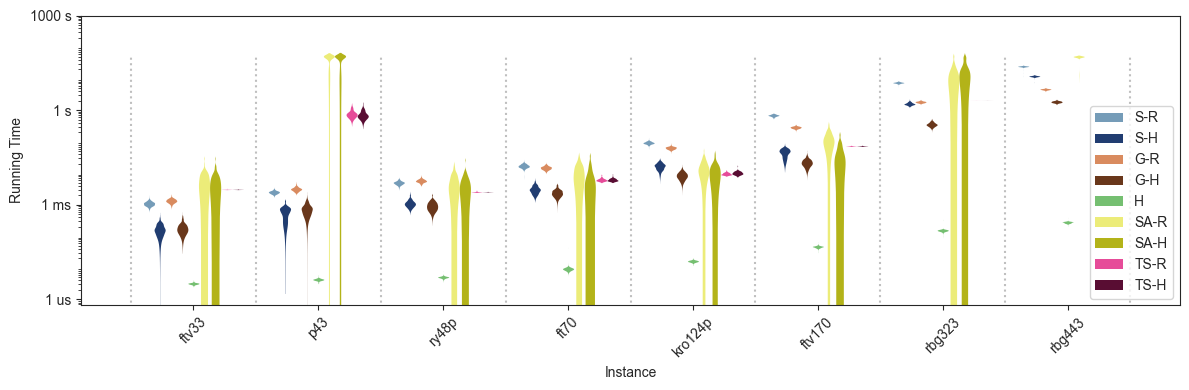

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_violin_by_attr(all_res_df, [*LS_METHODS, *LS_NN_METHODS, "H", *TS_METHODS, *SA_METHODS], selected_instances, "time", ax)

ax.legend()
ax.set_ylabel("Running Time")
ax.set_xlabel("Instance")
plt.yscale('log')
plt.yticks([10**i for i in range(3, 13, 3)], ["1 us", "1 ms", "1 s", "1000 s"])
plt.tight_layout()
plt.savefig("plots/3/violin_time.png")
plt.show()

C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


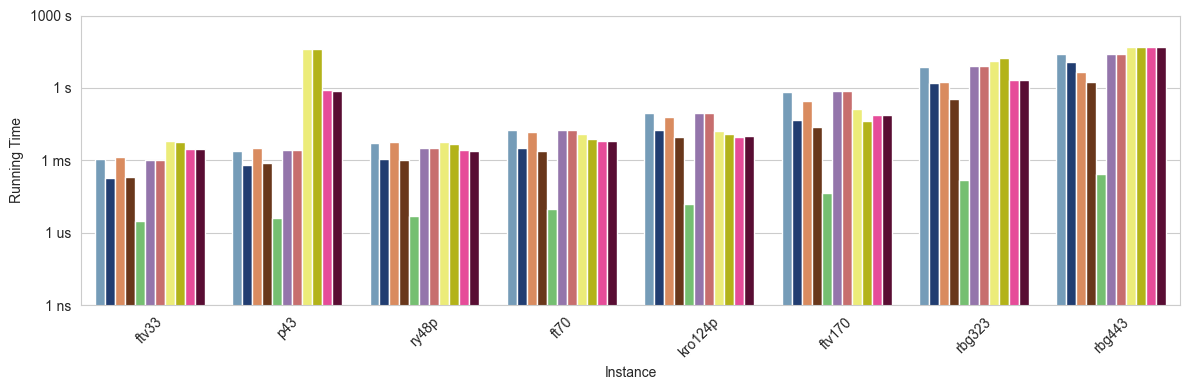

In [10]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plot_bars(stats_df, ORDER, selected_instances, "time_mean", ax, "time_std")
    ax.set_ylabel("Running Time")
    ax.set_xlabel("Instance")
    ax.get_legend().remove()
    
    plt.yscale('log')
    plt.yticks([10**i for i in range(0, 13, 3)], ["1 ns", "1 us", "1 ms", "1 s", "1000 s"])
    plt.tight_layout()
    plt.savefig("plots/3/bar_time.png")
    plt.show()

# Efficiency

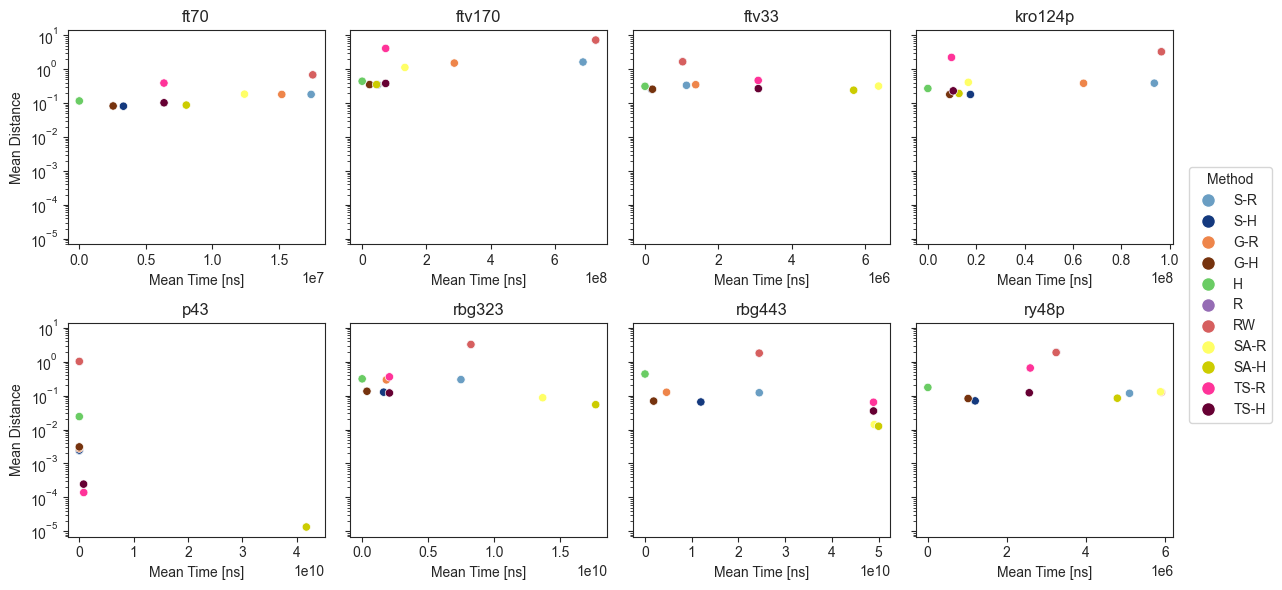

In [11]:
# plot mean time over mean distance for each method
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharey=True)

for instance, ax in zip(selected_instances, axs.flatten()):
    summary_subset_df = stats_df[(stats_df['instance'] == instance) & (stats_df['method'].isin(ORDER))]
    sns.scatterplot(
        x='time_mean',
        y='distance_mean',
        hue='method',
        data=summary_subset_df,
        ax=ax,
        alpha=1,
        palette=COLORS,
    )

    ax.set_xlabel("Mean Time [ns]")
    ax.set_ylabel("Mean Distance")
    ax.set_title(instance)
    ax.set_yscale('log')
    ax.get_legend().remove()


lgd = fig.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS[method], markersize=10, label=method) for method in ORDER],
    loc='center right',
    bbox_to_anchor=(1.07, 0.5),
    title="Method"
)
plt.tight_layout()
fig.savefig("plots/3/efficiency.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Number of Steps

C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


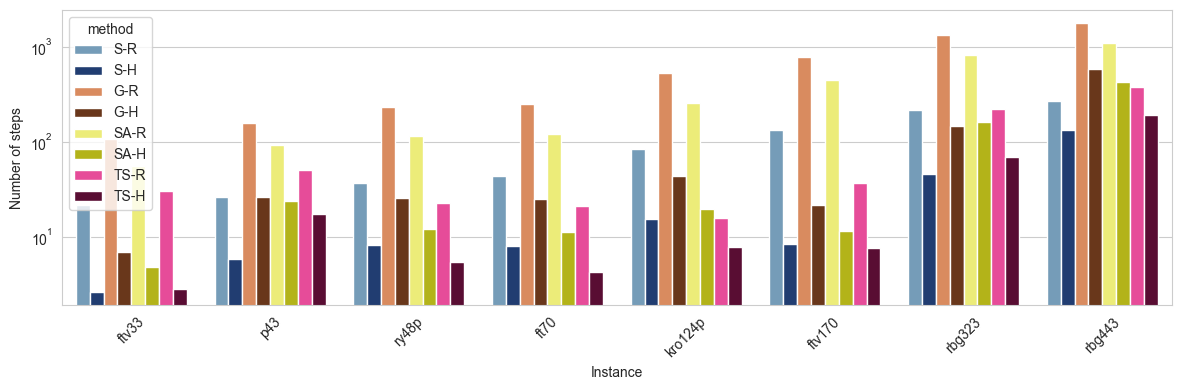

In [12]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plot_bars(stats_df, LS_METHODS + LS_NN_METHODS + TS_METHODS + SA_METHODS, selected_instances, "steps_mean", ax, "steps_std")
    ax.set_ylabel("Number of steps")
    ax.set_xlabel("Instance")
    plt.tight_layout()
    plt.yscale('log')
    plt.savefig("plots/3/bar_steps.png")
    plt.show()

# Number of Evaluations

C:\Users\njytwf\AppData\Local\Temp\ipykernel_6292\4037179348.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


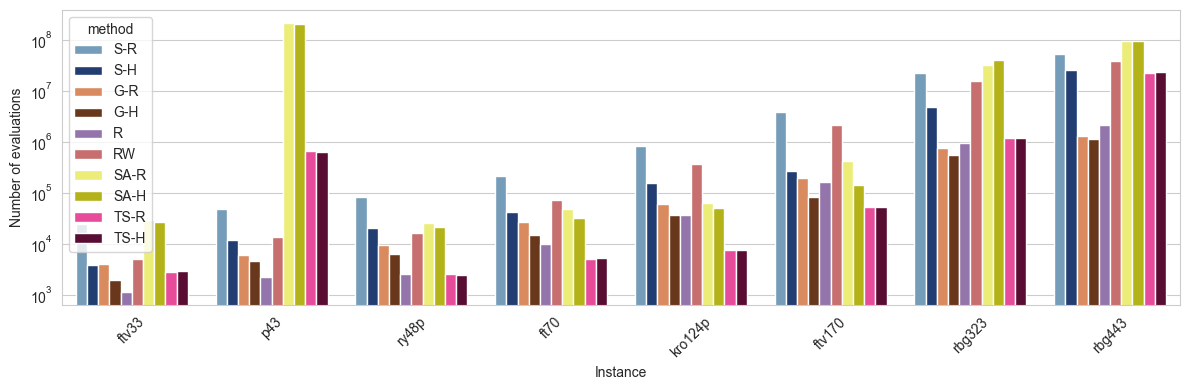

In [13]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plot_bars(stats_df, [*LS_METHODS, *LS_NN_METHODS, *RANDOM_METHODS, *TS_METHODS, *SA_METHODS], selected_instances, "evaluations_mean", ax, "evaluations_std")
    ax.set_ylabel("Number of evaluations")
    ax.set_xlabel("Instance")
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig("plots/3/bar_evaluations.png")
    plt.show()

In [14]:
sa_times = stats_df[stats_df["method"] == "SA-R"][["instance", "time_mean"]].to_dict(orient="records")

{row["instance"]: int(row["time_mean"]) for row in sa_times}

{'ftv33': 3043807,
 'p43': 6211856732,
 'ry48p': 2506905,
 'ft70': 5621784,
 'kro124p': 8673872,
 'ftv170': 71436792,
 'rbg323': 2057156201,
 'rbg443': 48906052898}

In [25]:
stats_df[stats_df["method"] == "SA-R"].apply(lambda row: 0.95 * (0.9925 ** (row["evaluations_mean"] / (0.6 * row["instance_size"]))), axis=1)

30    9.882436e-06
52    0.000000e+00
85    1.046494e-03
8     1.443986e-04
41    1.361422e-03
19    2.402065e-14
63    0.000000e+00
74    0.000000e+00
dtype: float64